In [54]:
# Core
import os
import importlib
import numpy as np
import pandas as pd
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Model / Feature selection / Scaling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.svm import SVC, LinearSVC

# Metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score
)

# Saving Model
import joblib


In [56]:
X_train = pd.read_csv('X_train.csv')
X_test  = pd.read_csv('X_test.csv')

y_train = pd.read_csv('Y_train.csv').squeeze("columns")  
y_test  = pd.read_csv('Y_test.csv').squeeze("columns")    # -> Series

# Optional sanity check
print(y_train.value_counts(dropna=False))
print(y_train.dtype)


Label
LumA      230
LumB      102
Normal     70
Basal      70
Her2       24
Name: count, dtype: int64
object


In [61]:
def get_irus_sampling_strategy(y):
    counts = Counter(y)
    majority_class = max(counts, key=counts.get)
    minority_class = min(counts, key=counts.get)
    imbalance_ratio = counts[majority_class] / counts[minority_class]
    
    # IRUS formula: inverse of square root of imbalance ratio
    sampling_ratio = 1 / np.sqrt(imbalance_ratio)
    
    # Calculate number of samples to keep for majority class
    n_samples_majority = int(counts[minority_class] / sampling_ratio)
    
    return {majority_class: n_samples_majority}

# Get IRUS sampling strategy based on training data
irus_strategy = get_irus_sampling_strategy(y_train)

# Define pipeline with IRUS and RFE for SVM
pipelineIrus = ImbPipeline([
    ('irus', RandomUnderSampler(sampling_strategy=irus_strategy, random_state=42)),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42))  # Using SVC as the final classifier
])

In [63]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

# RANDOM SEARCH
param_dist = {
    'svm__C': loguniform(1e-3, 1e3),   # ← MUCH better than fixed discrete list
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'svm__gamma': loguniform(1e-6, 1e-1)
}

rand = RandomizedSearchCV(
    estimator=pipelineIrus,
    param_distributions=param_dist,
    n_iter=50,                     # you decide budget
    scoring='f1_weighted',
    cv=3,
    n_jobs= -2,
    verbose=1,
    random_state=42
)

rand.fit(X_train, y_train)
print(rand.best_params_)
best_model1 = rand.best_estimator_


Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'svm__C': 793.2047656808546, 'svm__gamma': 0.0002156822801926397, 'svm__kernel': 'linear'}


    mean_test_score  param_svm__C  param_svm__gamma param_svm__kernel
23         0.784872      1.333539          0.063953            linear
11         0.784872    793.204766          0.000216            linear
30         0.784872     23.661540          0.007184            linear
14         0.784872     70.857217          0.000033            linear
41         0.784872      2.396919          0.003003            linear
45         0.784872      5.573452          0.000030            linear
24         0.784872      0.214815          0.000023            linear
21         0.783217      0.234910          0.042983              poly
0          0.783217      0.176702          0.056698              poly
43         0.783217      0.016534          0.051793              poly

Test Accuracy (best model): 0.75

Model Evaluation on Test Data:
              precision    recall  f1-score   support

       Basal       0.93      0.82      0.88        17
        Her2       0.75      0.86      0.80         7
 

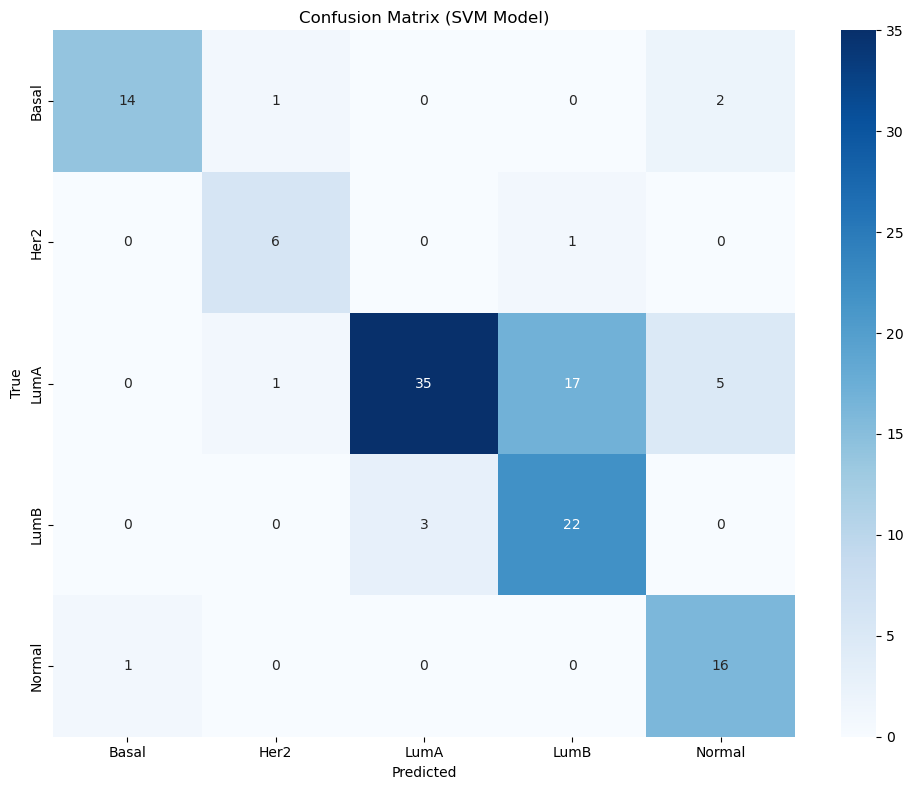

In [64]:
import pandas as pd

results_df = pd.DataFrame(rand.cv_results_)

# sort by best score (RandomizedSearch stores mean test score column)
results_df = results_df.sort_values(by='mean_test_score', ascending=False)

top10 = results_df.head(10)

cols_to_show = ['mean_test_score', 'param_svm__C', 'param_svm__gamma', 'param_svm__kernel']
print(top10[cols_to_show])

# Evaluate the model on test data
y_pred = best_model1.predict(X_test)
print("\nTest Accuracy (best model):", accuracy_score(y_test, y_pred))
print("\nModel Evaluation on Test Data:")
print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (SVM Model)')
plt.tight_layout()
plt.show()
